In [1]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Step 1: Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force reauthentication

# Step 2: Install required libraries (if needed)
!pip install tensorflow

# Step 3: Import libraries
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization,
    GlobalAveragePooling1D, Reshape, MultiHeadAttention, Conv2D, BatchNormalization, MaxPooling2D
)
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Step 4: Verify GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Step 5: Load the preprocessed AST features from Google Drive
with open("/content/drive/My Drive/project/ast_features.pkl", "rb") as f:
    ast_features, labels = pickle.load(f)

# Step 6: Convert labels to categorical
num_classes = len(np.unique(labels))
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(ast_features, labels, test_size=0.2, random_state=42)

# Step 8: Ensure correct input shape (batch_size, 500, 128, 1)
X_train = np.transpose(X_train, (0, 2, 1))  # Transpose to (batch_size, 500, 128)
X_test = np.transpose(X_test, (0, 2, 1))    # Transpose to (batch_size, 500, 128)

# Step 9: Truncate sequences to reduce sequence length
X_train = X_train[:, :250, :]  # Reduce sequence length to 250
X_test = X_test[:, :250, :]    # Reduce sequence length to 250

# Step 10: Add channel dimension
X_train = np.expand_dims(X_train, axis=-1)  # Shape: (batch_size, 250, 128, 1)
X_test = np.expand_dims(X_test, axis=-1)    # Shape: (batch_size, 250, 128, 1)

# Step 11: Define the model
def convolutional_frontend(inputs):
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Reshape for Transformer
    x = Reshape((-1, x.shape[-1]))(x)  # Ensure correct shape for MultiHeadAttention
    return x

def transformer_block(x):
    for _ in range(2):  # Reduce to 2 Transformer layers
        attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # Reduce num_heads and key_dim
        attn_output = Dense(256, activation="relu")(attn_output)  # Reduce units
        x = Dense(256, activation="relu")(x)  # Reduce units
        x = LayerNormalization()(x + attn_output)
        ffn_output = Dense(256, activation="relu")(x)  # Reduce units
        x = LayerNormalization()(x + ffn_output)
    return x

def create_ast_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)  # (250, 128, 1)

    # Feature Extraction
    x = convolutional_frontend(inputs)

    # Transformer Layers
    x = transformer_block(x)

    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)

    # Fully Connected Layer
    x = Dense(128, activation="relu")(x)  # Reduce units
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Build and Compile Model
    model = keras.Model(inputs, outputs)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=AdamW(learning_rate=0.001),
        metrics=["accuracy"]
    )
    return model

# Step 12: Create Model
input_shape = X_train.shape[1:]
model = create_ast_model(input_shape, num_classes)

# Step 13: Define Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Step 14: Train Model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=8,  # Reduced batch size
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stop]
)


# Step 15: Save Model (Updated to Keras native format)
model.save("/content/drive/My Drive/project/ast_transformer_model_optimized.keras")  # Changed .h5 to .keras


# Step 16: Save History as csv file
import pandas as pd
history_path = "/content/drive/My Drive/project/ast_training_history.csv"
pd.DataFrame(history.history).to_csv(history_path, index=False)

# Step 17: Save X_test and y_test
np.save("/content/drive/My Drive/project/X_test.npy", X_test)
np.save("/content/drive/My Drive/project/y_test.npy", y_test)

# Step 18: Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=8)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Mounted at /content/drive
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/30
874/874 ━━━━━━━━━━━━━━━━━━━━ 129s 105ms/step - accuracy: 0.2836 - loss: 1.9851 - val_accuracy: 0.3131 - val_loss: 1.8726 - learning_rate: 0.0010
Epoch 2/30
874/874 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.4473 - loss: 1.4970 - val_accuracy: 0.1935 - val_loss: 3.2965 - learning_rate: 0.0010
Epoch 3/30
874/874 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.4927 - loss: 1.3412 - val_accuracy: 0.4974 - val_loss: 1.3687 - learning_rate: 0.0010
Epoch 4/30
874/874 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.5427 - loss: 1.2403 - val_accuracy: 0.5146 - val_loss: 1.3447 - learning_rate: 0.0010
Epoch 5/30
874/874 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.5746 - loss: 1.1660 - val_accuracy: 0.5283 - val_loss: 1.3946 - learning_rate: 0.0010
Epoch 6/30
874/874 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.5983 - loss: 1.1013 - val_accuracy: 0.4493 - val_los

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 98 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step


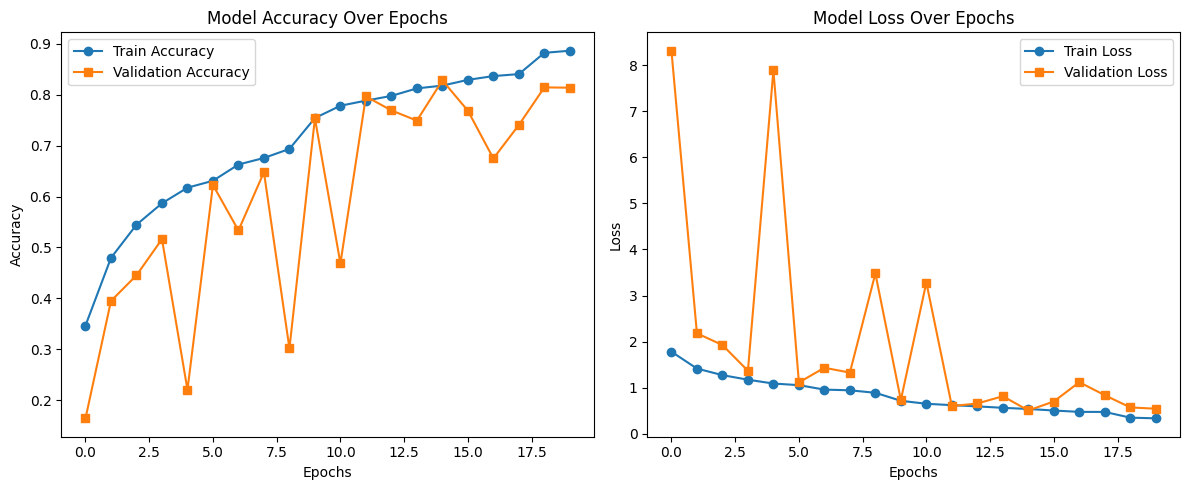

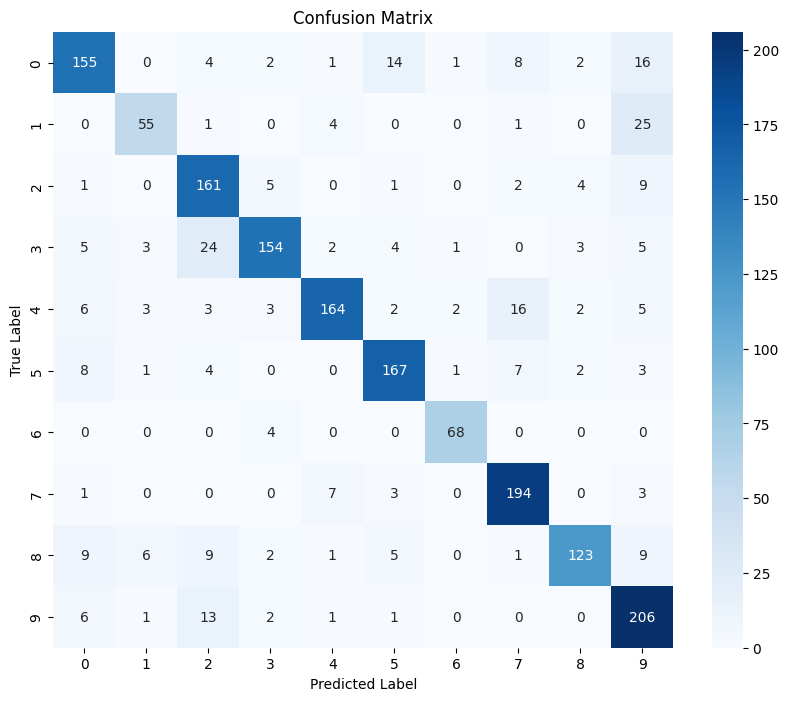

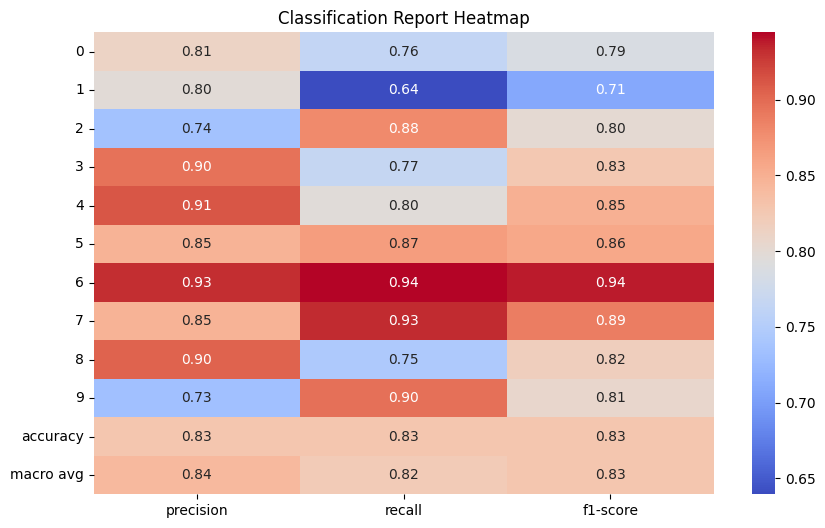

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Step 1: Load Training History
history_path = "/content/drive/My Drive/ast_training_history.csv"
history_df = pd.read_csv(history_path)

# Step 2: Load Test Data
X_test = np.load("/content/drive/My Drive/X_test.npy")
y_test = np.load("/content/drive/My Drive/y_test.npy")

# Step 3: Load Model
from tensorflow.keras.models import load_model
model_path = "/content/drive/My Drive/ast_transformer_model_optimized.keras"
model = load_model(model_path)

# Step 4: Get Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Step 5: Define Plot Functions
def plot_training_history(history_df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy Plot
    ax[0].plot(history_df['accuracy'], label='Train Accuracy', marker='o')
    ax[0].plot(history_df['val_accuracy'], label='Validation Accuracy', marker='s')
    ax[0].set_title("Model Accuracy Over Epochs")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    # Loss Plot
    ax[1].plot(history_df['loss'], label='Train Loss', marker='o')
    ax[1].plot(history_df['val_loss'], label='Validation Loss', marker='s')
    ax[1].set_title("Model Loss Over Epochs")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def plot_classification_report(y_true, y_pred, classes):
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    # Convert to DataFrame
    report_df = pd.DataFrame(report_dict).transpose().iloc[:-1, :-1]  # Remove last row (accuracy, macro avg)

    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Classification Report Heatmap")
    plt.show()

# Step 6: Visualize Results
plot_training_history(history_df)
plot_confusion_matrix(y_test_classes, y_pred_classes, classes=np.arange(y_test.shape[1]))
plot_classification_report(y_test_classes, y_pred_classes, classes=np.arange(y_test.shape[1]))
